In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy
from HessianMCMC import HessianMCMC

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [34]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [35]:
def divide(a,b):
    '''
     Tensorflow safe divide
    '''
    return tf.math.divide_no_nan(a,b)

def A(x1,z1,x2,z2):
    numerator = (x2-x1)*(x1*z2-x2*z1)
    denominator = (x2-x1)**2 + (z2-z1)**2
    return divide(numerator,denominator)

def B(x1,z1,x2,z2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return divide((z1-z2),(x2-x1))


def theta_new(xn,zn):
    
    m = tf.atan(divide(zn,xn))

    m = tf.where(m<0, m + pi, m ) 

    m = tf.where(m == 0, m + pi/2, m)

    return m
 
    
def Z_new(x1,z1,x2,z2):
    
    ## let's do not allow 1) points at origin
    ##                    2) two points in a sequence have the same x coordinate
    
    
    theta1 = theta_new(x1,z1)
    theta2 = theta_new(x2,z2)
    
    r1 = (tf.sqrt(x1**2.+z1**2.))
    r2 = (tf.sqrt(x2**2.+z2**2.))

    _A = A(x1,z1,x2,z2)
    _B = B(x1,z1,x2,z2)
    
    
    Z_result = _A*((theta1-theta2)+_B*tf.math.log(divide(r1,r2)))
    

    return Z_result 
 
@tf.function
def grav_new(x,z):
    
    
    thick = thickness
    x_obv = tf.linspace(Range[0],Range[1],obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    
    
    tx = tf.transpose(tf.tile(x,[1,obs_N]))

    x_tile = tf.expand_dims(tx,axis = 2)

    tz = tf.transpose(tf.tile(z,[1,obs_N]))

    z_tile = tf.expand_dims(tz,axis = 2)
    
    
    x_obv_tile = tf.expand_dims(x_obv,axis = 1)
    x_obv_tile = tf.tile(x_obv_tile,[1,x.shape[0]])
    x_obv_tile = tf.reshape(x_obv_tile,[obs_N,x.shape[0],1])


    z_obv_tile = tf.expand_dims(y_obv,axis = 1)
    z_obv_tile = tf.tile(z_obv_tile,[1,x.shape[0]])
    z_obv_tile = tf.reshape(z_obv_tile,[obs_N,x.shape[0],1])
    
    
    _x = x_tile - x_obv_tile
    _z = z_tile - z_obv_tile
    
    x_ = tf.concat([_x, tf.reshape(_x[:,0],shape = [obs_N,1,1])],axis = 1)
    z_ = tf.concat([_z, tf.reshape(_z[:,0],shape = [obs_N,1,1])],axis = 1)
    
    x1 = x_[:,0:-1]
    x2 = x_[:,1:]
    z1 = z_[:,0:-1]
    z2 = z_[:,1:]
    
    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3
    
    gravity = 2*G*rho*tf.reduce_sum(-Z_new(x1,z1,x2,z2),axis = 1)
    
    return tf.squeeze(gravity)


In [36]:

@tf.function
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    
    Gm_ = grav_new(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
            +mvn_likelihood.log_prob(D))

@tf.function
def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

In [37]:
## define some numbers
Number_para = 15
obs_N = 15
number_burnin = 1000
number_sample = 2000
steps_gradient_decent = 100

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-100)
thickness = constant64(10)

Range = constant64([-200.,200.])

In [38]:
# prior
mu_prior = -100.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 10.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)


# likelihood
sig_e = constant64(0.00000001)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

## Define the ground truth

In [39]:
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
#control_index with non-even distribution
control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

# define some points to minimize the artifacts
number_of_fixpoints = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(Range[0]-200,Range[0]-10,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(Range[1]+10,Range[1]+200,number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))

## define the true z-values
True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)
True_position_sin = 30*tf.sin(0.03*control_index)+depth

#### Gaussian Process

In [40]:
## train the gp model based on True_position


# define x , z
points = tf.stack([control_index,True_position],axis = -1)


# add some points to eliminate the bondary artifacts
points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

## define the GP parameters
amplitude = tfp.util.TransformedVariable(
      2, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
      20, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
    
observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-1), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

# x- index used to construct GP model
observation_index_points = tf.reshape(points[:,0],[Number_para+2*number_of_fixpoints,1])


# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
# @tf.function
# def optimize():
#     with tf.GradientTape() as tape:
#         loss = -gp.log_prob(points[:,1])
#     grads = tape.gradient(loss, gp.trainable_variables)
#     optimizer.apply_gradients(zip(grads, gp.trainable_variables))
#     return loss
# # First train the model, then draw and plot posterior samples.
# for i in range(1000):
#     neg_log_likelihood_ = optimize()
    
    
model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],
                                         observation_index_points[-1,0],
                                         Number_para+4),
                             axis =1)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=model_index,
    observation_index_points=observation_index_points,
    observations=points[:,1],
    observation_noise_variance=observation_noise_variance)

model_position = gprm.mean()

model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,
                                                                axis = [-1])],
                                                axis = -1)],
                                         shape = [model_position.shape[0]*2,1])
model_index_complete = tf.concat([model_index,tf.reverse(model_index,
                                                         axis = [0])],
                                 axis = 0)

In [41]:
gp.trainable_variables

(<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.6931471805599453>,
 <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=2.995732273553991>,
 <tf.Variable 'observation_noise_variance:0' shape=() dtype=float64, numpy=-1.0>)

In [42]:
def GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position):
    '''
        Arguments:
            kernel: trained GP kernal
            
        return:
            GP interpolated model index and model psition
            
    '''
    ## define how many points interpolated between control points
    resolution = 5
    
    
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)
    
    # x-index where we want to interpolate
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)

    model_position = gprm.mean()

    ## model_complete contains the extended polygon used to do gravity calculation
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[0]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete

x_true,z_true = GaussianProcess_model(kernel,observation_index_points,control_index,True_position_sin)

In [43]:
Data = grav_new(x_true,z_true)

In [44]:
joint_log_post(Data,True_position)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<tf.Tensor: shape=(), dtype=float64, numpy=-7752.641586096409>

In [45]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=Range[1],ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = grav_new(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

def Draw_inter(_control_index,_control_position,z_true = None,R = Range[1], ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
        
    x_,z_ = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    ax.plot(x_,z_)
    ## proposal is red
    ax.scatter(control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)

In [46]:
# _x,_z = GaussianProcess_model(kernel,observation_index_points,control_index,True_position_sin)
# temp = np.zeros_like(_z)
# temp[0]= - 0.1;temp[-1] = 0.1
# temp[int(temp.shape[0]/2-1)] = -.1
# temp[int(temp.shape[0]/2)] = .1

# _z = _z+temp

# simulated_gravity(_x,_z)

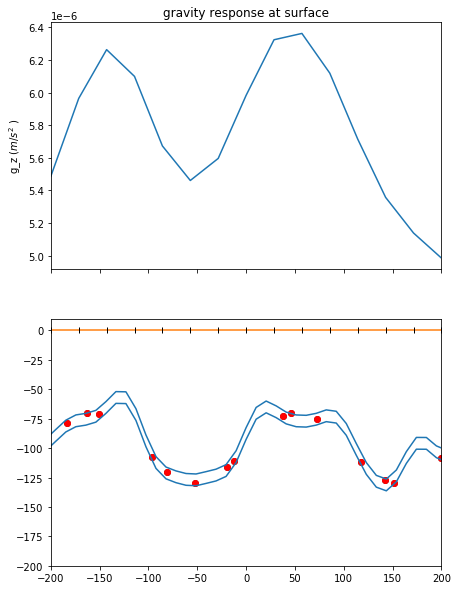

In [47]:
def Draw(_control_index,_control_position,ax = None,**args):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    simulated_gravity(_x,_z,ax = ax[0],**args)
    Draw_inter(_control_index,_control_position,ax = ax[1],z_true =True_position_sin)
Draw(control_index,True_position_sin)

In [48]:
mu_init = tf.random.normal([Number_para],mean = depth, stddev = -10,seed = 1,dtype = tf.float64) # initial parameters

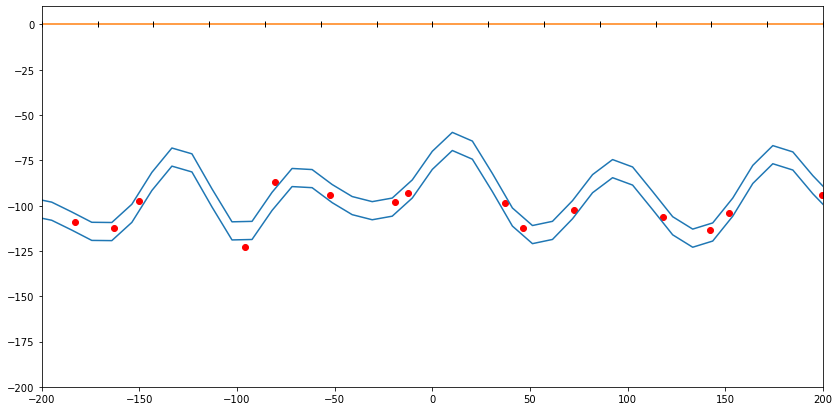

In [49]:
steps_gradient_decent = 500
Draw_inter(control_index,mu_init)

In [50]:
negative_log_posterior(Data,mu_init)

<tf.Tensor: shape=(), dtype=float64, numpy=11336.673945292263>

loss tf.Tensor(11336.673945292263, shape=(), dtype=float64)
grad tf.Tensor(
[ -90.83206327   -1.12537269 -166.48394078  -75.27021912   68.53483986
   84.44363143   47.00852068   42.14199813  -11.82191083  -10.97035603
  -58.59379064  -16.66097943  -11.40375971  102.58547806  122.1610244 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-108.75942062 -112.48795137  -97.33800266 -122.83138769  -87.24318524
  -94.0554936   -98.32157406  -92.82533858  -98.3521224  -112.1927064
 -102.15391206 -105.99974467 -113.40392209 -104.43682383  -94.43148544], shape=(15,), dtype=float64)
Iteration 0


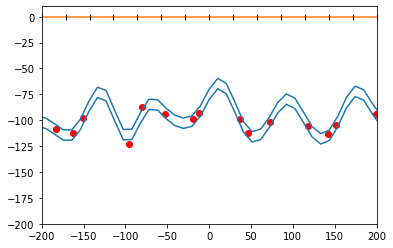

loss tf.Tensor(5526.239377189979, shape=(), dtype=float64)
grad tf.Tensor(
[-6.17773295e+01 -1.24148247e+00 -1.12537829e+02 -3.01382685e+01
  5.30829502e+01  6.34147639e+01  3.67522848e+01  1.92452587e+01
 -2.69453334e+01 -6.60248674e+00 -6.27277109e+01 -2.56761287e+01
 -5.94194077e-03  4.54547052e+01  5.96462638e+01], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-101.21603017 -112.47239479  -83.27047387 -117.60037238  -93.36724025
 -101.3592238  -102.48705654  -95.77824491  -96.30618483 -111.32411999
  -95.94443532 -103.68091034 -112.97676834 -111.20515733 -102.87647782], shape=(15,), dtype=float64)
Iteration 100


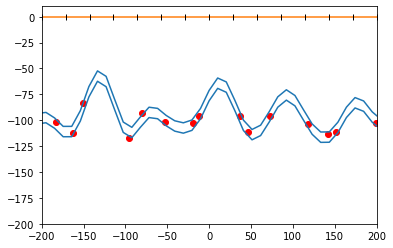

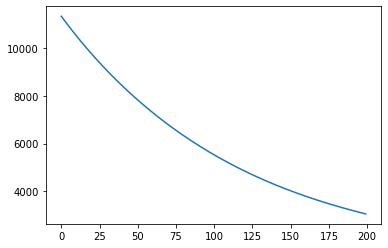

In [68]:
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)

    mu = mu-tf.multiply(constant64(0.001),dlossdmu)
    if i % 100 == 0:
        print('loss',loss)
        print('grad',dlossdmu)
        print('mu:',mu)
        f,ax = plt.subplots()
        Draw_inter(control_index,mu,ax = ax)
        print('Iteration',i)
        plt.show()
plt.plot(lost)

In [52]:
negative_log_posterior(Data,True_position_sin)

<tf.Tensor: shape=(), dtype=float64, numpy=166.58168468008552>

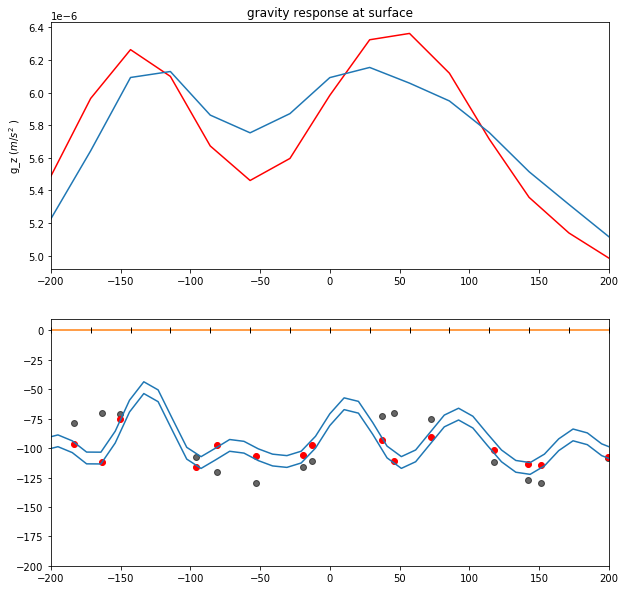

In [69]:
f,ax = plt.subplots(2,figsize =(10,10))
x_obs = np.linspace(Range[0],Range[1],obs_N)
ax[0].plot(x_obs,Data,'r')
Draw(control_index,mu,ax)

In [54]:
MAP = mu

In [55]:
with tf.GradientTape() as t:
    t.watch(MAP)
    with tf.GradientTape() as tt:
        tt.watch(MAP)
        loss = negative_log_posterior(Data,MAP)
    jac = tt.gradient(loss,MAP)
hess = t.gradient(jac,MAP)
MAP = MAP+tf.ones_like(MAP)

In [56]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()
New_Hessian = Full_Hessian()

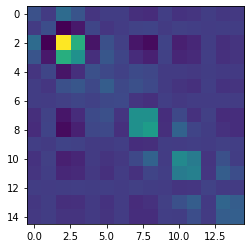

In [57]:
plt.imshow(New_Hessian)

In [58]:
covariance = tf.linalg.inv(New_Hessian)

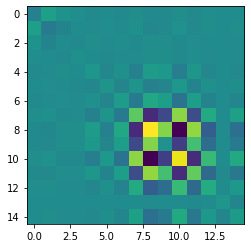

In [59]:
plt.imshow(covariance)

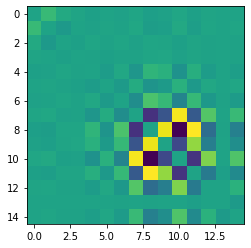

In [60]:
H = covariance.numpy()

for i in range(Number_para):
    H[i,i] = 0
plt.imshow(H)

In [70]:
h = HessianMCMC(Number_para,negative_log_posterior,Data,MAP,cov_prior,number_sample,number_burnin,mu_init)

In [73]:
accepted, rejected = h.run_chain_hessian()